# Tutorial 1: Probabilistic Modeling and Importance Sampling

This tutorial shows how to write a probabilistic model in Gen, and how to implement a simple inference algorithm for this model.

Specifically, will implement an inference algorithm that infers the probable destination of an autonomous agent from its observed motion in a two-dimensional environment with obstacles. The algorithm will employ a generative model that includes (i) a prior distribution on the destination of the agent, and (ii) an algorithmic model for how the agent plans its movement based on its destination, (iii) a statistical model of the noise in our measurements of the agent's motion. This class of model draws inspiration from models of human cognition from the computational cognitive science literature [1]. We use this model because the results of inference are intuitive from everyday life and are straightforward to visualize.

We will use importance sampling for inference. We will start with a basic importance sampling algorithm that uses a default proposal distribution, and then we will develop custom proposal distributions that give more efficient importance sampling algorithms.

We will break down this modeling and inference tasks into the following steps:

- **Step 1:** Implement geometric primitives for a two-dimensional scene that contains obstacles.

- **Step 2:** Implement a planning algorithm that takes the two-dimensional scene, and a starting point within the scene, and a destination point within the scene, and generates an efficient (short) path from the starting point to the destination point.

- **Step 3:** Write a generative function for the observed motion of of an autonomous agent, using the Julia code written in Steps 1 and 2.

- **Step 4:** Explore the the assumptions, or prior beliefs, that our inferences will be based on, by sampling many traces of the generative function and visualizing them.

- **Step 5:** Use a simple importance sampling algorithm to sample probable destination points for the agent, given an example data set of observed motion.

- **Step 6:** Writing a custom proposal distribution for use with importance sampling.

- **Step 7:** Learning a custom proposal distribution for use with importance sampling.

[1] Baker, Chris L., Rebecca Saxe, and Joshua B. Tenenbaum. "Action understanding as inverse planning." Cognition 113.3 (2009): 329-349.

### Load packages

First, we load the `Gen` Julia package, which brings into scope the built-in Gen modeling languages and inference library methods. We won't use Gen itself until Step 3, but we load it here because packages are usually loaded at the beginning of a script.

In [1]:
using Gen

┌ Info: Recompiling stale cache file /home/marcoct/.julia/compiled/v1.0/Gen/OEZG1.ji for Gen [ea4f424c-a589-11e8-07c0-fd5c91b9da4a]
└ @ Base loading.jl:1190


We also load the `GenViz` Julia package, which is a JavaScript-based visualization framework designed for use with Gen:

In [2]:
using GenViz

We start a visualization server that we will use throughout the notebook:

In [3]:
server = VizServer(8000)
sleep(1)

We will also make use of the [`PyPlot`](https://github.com/JuliaPy/PyPlot.jl) Julia package, which wraps [matplotlib](https://matplotlib.org/):

In [4]:
using PyPlot

We will be using the `median` method from the `Statistics` package:

In [5]:
using Statistics: median

Finally, we will need the `JLD` Julia package to load some precomputed data from disk:

In [6]:
using JLD

## Step 1: Implement geometry of a two-dimensional scene with obstacles.

This step is implemented using regular Julia code. We have provided some of the basic geometric primitives in the following file:

In [7]:
include("geometric_primitives.jl");

This file defines two-dimensional `Point` data type with fields `x` and `y`:

In [8]:
point = Point(1.0, 2.0)
println(point.x)
println(point.y)

1.0
2.0


The file defines a method that computes the distance between two points: 

In [9]:
dist(Point(1.0, 1.0), Point(0.0, 0.0))

1.4142135623730951

The file also defines an `Obstacle` data type, which represents a polygonal obstacle in a two-dimensional scene, that is constructed from a list of vertices. Here, we construct a square:

In [10]:
obstacle = Obstacle([Point(0.0, 0.0), Point(1.0, 0.0), Point(0.0, 1.0), Point(1.0, 1.0)]);

The file also defines a method to test whether an obstacle intersects with a line segment, which is defined by a start point and an end point:

In [11]:
println(obstacle_intersects_line_segment(obstacle, Point(-1.0, 0.5), Point(2.0, 0.5)))

true


In [12]:
println(obstacle_intersects_line_segment(obstacle, Point(-1.0, 1.5), Point(2.0, 1.5)))

false


Given these geometric primitives, we define a data type to represent the two-dimensional scene. The scene spans a rectangle of on the two-dimensional x-y plane, and contains a list of obstacles. Each obstacle is a polygon defined by a list of vertex points. We also define a method to compute whether a given line is obstructed by any obstacles in the scene.

In [13]:
struct Scene
    xmin::Float64
    xmax::Float64
    ymin::Float64
    ymax::Float64
    obstacles::Vector{Obstacle}
end

Scene(xmin, xmax, ymin, ymax) = Scene(xmin, xmax, ymin, ymax, Obstacle[])

add_obstacle!(scene, obstacle::Obstacle) = push!(scene.obstacles, obstacle)

function line_is_obstructed(scene::Scene, a1::Point, a2::Point)
    for obstacle in scene.obstacles
        if obstacle_intersects_line_segment(obstacle, a1, a2)
            return true
        end
    end
    false
end

line_is_obstructed (generic function with 1 method)

Finally, we write some methods that allow us to concisely construct walls (line-shaped obstacles that are either vertically or horizontally oriented), and square-shaped obstacles (representing trees).

In [14]:
function make_wall(vertical::Bool, start::Point, length::Float64, thickness::Float64)
    vertices = Vector{Point}(undef, 4)
    vertices[1] = start
    dx = vertical ? thickness : length
    dy = vertical ? length : thickness
    vertices[2] = Point(start.x + dx, start.y)
    vertices[3] = Point(start.x + dx, start.y + dy) 
    vertices[4] = Point(start.x, start.y + dy)
    Obstacle(vertices)
end 

function make_tree(center::Point, size::Float64)
    vertices = Vector{Point}(undef, 4)
    vertices[1] = Point(center.x - size/2, center.y - size/2)
    vertices[2] = Point(center.x + size/2, center.y - size/2)
    vertices[3] = Point(center.x + size/2, center.y + size/2)
    vertices[4] = Point(center.x - size/2, center.y + size/2)
    Obstacle(vertices)
end

make_tree (generic function with 1 method)

We now construct a scene value that we will use in the rest of the tutorial:

In [15]:
scene = Scene(0, 1, 0, 1)
add_obstacle!(scene, make_tree(Point(0.30, 0.20), 0.1))
add_obstacle!(scene, make_tree(Point(0.83, 0.80), 0.1))
add_obstacle!(scene, make_tree(Point(0.80, 0.40), 0.1))
horizontal = false
vertical = true
wall_thickness = 0.02
add_obstacle!(scene, make_wall(horizontal, Point(0.20, 0.40), 0.40, wall_thickness))
add_obstacle!(scene, make_wall(vertical, Point(0.60, 0.40), 0.40, wall_thickness))
add_obstacle!(scene, make_wall(horizontal, Point(0.60 - 0.15, 0.80), 0.15 + wall_thickness, wall_thickness))
add_obstacle!(scene, make_wall(horizontal, Point(0.20, 0.80), 0.15, wall_thickness))
add_obstacle!(scene, make_wall(vertical, Point(0.20, 0.40), 0.40, wall_thickness));

We visualize the scene below:

In [16]:
info = Dict("scene" => scene)
viz = Viz(server, joinpath(@__DIR__, "overlay-viz/dist"), info)
displayInNotebook(viz)

<!---->>

	<!----><!----><!----><!----><!---->

## Step 2: Implement a simple planning algorithm

In this step, we implement a simple planning algorithm based on the rapidly exploring random tree (RRT) algorithm [2]. The planning algorithm will take as input (i) the scene, (ii) the start point, and (iii) the destination point, and will produce a sequence of points that starts with the start point and ends with the destination point, such the line of sight between each consecutive point does not intersect any obstacles, or return failure if no path could be found.

[2] Rapidly-exploring random trees: A new tool for path planning. S. M. LaValle. TR 98-11, Computer Science Dept., Iowa State University, October 1998,

We load an implementation of the RRT algorithm from the following file:

In [17]:
include("rrt.jl");

The file defines a method `generate_rrt` that takes a scene, a starting point, and algorithm parameters, and returns an `RRT` value, which represents a tree rooted at the starting point that fills the scene.

In [18]:
start = Point(0.1, 0.1)
tree = generate_rrt(scene, start, 300, 3.0);

We visualize the resulting tree on top of the scene:

In [19]:
info = Dict("start"=> start, "scene" => scene, "tree_edges" => get_edges(tree))
viz = Viz(server, joinpath(@__DIR__, "overlay-viz/dist"), info)
displayInNotebook(viz)

>

	<!----><!----> <!----><!---->

Given a RRT, and a destination point, we can find a path from the root of the RRT to the destination point, by finding a node on the tree that has a clear line-of-sight to the destination node, and is also as close as possible to the destination node. We then walk back from this node along the edges of the tree to the route to construct the path. If there is no node on the tree with a clear line-of-sight to the destination, we return the value `nothing`:

In [20]:
struct Path
    points::Vector{Point}
end

function get_path_to_dest(tree::RRT, destination::Point)
    
    # find a node in the tree with a clear line-of-sight to the destination
    best_node = tree.nodes[1]
    min_cost = Inf
    path_found = false
    for node in tree.nodes
        clear_path = !line_is_obstructed(scene, node.conf, destination)
        cost = node.dist_from_start + (clear_path ? dist(node.conf, destination) : Inf)
        if cost < min_cost
            path_found = true
            best_node = node
            min_cost = cost
        end
    end
    
    if path_found
        
        # walk from the best node to the root of the tree to construct the path
        points = Point[destination]
        node = best_node
        while node.parent != nothing
            push!(points, node.conf)
            node = node.parent
        end
        push!(points, root(tree).conf)
        Path(reverse(points))
    else
        
        # return nothing if no path was found
        nothing
    end
end

get_path_to_dest (generic function with 1 method)

We visualize an example path below:

In [21]:
function get_edges(path::Path)
    edges = Tuple{Point,Point}[]
    for i=1:length(path.points)-1
        push!(edges, (path.points[i], path.points[i+1]))
    end
    edges
end

get_edges (generic function with 2 methods)

In [22]:
dest = Point(0.5, 0.5)
path = get_path_to_dest(tree, dest)

Path(Point[Point(0.1, 0.1), Point(0.00651803, 0.306943), Point(0.0236618, 0.886144), Point(0.389054, 0.896179), Point(0.5, 0.5)])

In [23]:
info = Dict("start"=> start, "dest" => dest, "scene" => scene,
    "tree_edges" => get_edges(tree), "path_edges" => get_edges(path))
viz = Viz(server, joinpath(@__DIR__, "overlay-viz/dist"), info)
displayInNotebook(viz)

>

 <!----> <!---->

The paths along the tree that are generated by the RRT algorithm are generally not very direct. We want our agent to take fairly direct paths from its starting location to the destination. Therefore, we use the following path-refinement procedure to optimize the path points to shorten the length of the path while still avoiding obstruction by obstacles. You don't need to worry about the details of this procedure.

In [24]:
function refine_path(scene::Scene, original::Path, iters::Int, std::Float64)
    new_points = copy(original.points)
    num_interior_points = length(original.points) -2
    if num_interior_points == 0
        return original
    end
    for i=1:iters
        
        # propose an adjustment to one of the interior points on the path (not the first or last point)
        point_idx = 2 + (i % num_interior_points)
        prev_point = new_points[point_idx-1]
        point = new_points[point_idx]
        next_point = new_points[point_idx+1]
        adjusted_point = Point(point.x + randn() * std, point.y + randn() * std)
        
        # check if the new path is obstructed by obstacles
        ok_backward = !line_is_obstructed(scene, prev_point, adjusted_point)
        ok_forward = !line_is_obstructed(scene, adjusted_point, next_point)
        
        # accept the adjustment if it is not obstructed by obstacles and it reduces the length of the path
        if ok_backward && ok_forward
            new_dist = dist(prev_point, adjusted_point) + dist(adjusted_point, next_point)
            cur_dist = dist(prev_point, point) + dist(point, next_point)
            if new_dist < cur_dist
                new_points[point_idx] = adjusted_point
            end
        end
    end
    Path(new_points)
end

refine_path (generic function with 1 method)

In [25]:
path = refine_path(scene, path, 2000, 1.)
info = Dict("start"=> start, "dest" => dest, "scene" => scene,
    "tree_edges" => get_edges(tree), "path_edges" => get_edges(path))
viz = Viz(server, joinpath(@__DIR__, "overlay-viz/dist"), info)
displayInNotebook(viz)

>

 <!----> <!---->

Finally, we combine each of the steps we just defined into a path-planning function. If a path could not be found, we return the value `nothing`. Otherwise, we return a `Path` value The path-planning function has parameters for how to grow the RRT (`rrt_iters` and `rrt_dt`) and how to perform the refinement (`refine_iters` and `refine_std`).

In [26]:
struct PlannerParams
    rrt_iters::Int
    rrt_dt::Float64
    refine_iters::Int
    refine_std::Float64
end

function plan_path(start::Point, dest::Point, scene::Scene, params::PlannerParams)
    
    # Generate a rapidly exploring random tree
    tree = generate_rrt(scene, start, params.rrt_iters, params.rrt_dt)

    # Find a route from the root of the tree to a node on the tree that has a line-of-sight to the destination
    maybe_path = get_path_to_dest(tree, dest)
    
    if maybe_path == nothing
        
        # No route found
        return (nothing, tree)
    else
        
        # Route found
        path = something(maybe_path)
        refined_path = refine_path(scene, maybe_path, params.refine_iters, params.refine_std)
        return (refined_path, tree)
    end
end



plan_path (generic function with 1 method)

We can now run the end-to-end path planning procedure. Run the cell below a few times to get a sense for the variability in the path planner.

In [27]:
(path, tree) = plan_path(start, dest, scene, PlannerParams(300, 3.0, 2000, 1.))
info = Dict("start"=> start, "dest" => dest, "scene" => scene,
    "tree_edges" => get_edges(tree), "path_edges" => get_edges(path))
viz = Viz(server, joinpath(@__DIR__, "overlay-viz/dist"), info)
displayInNotebook(viz)

>

 <!----> <!---->

We also need a model for how the agent moves along its path.
We will assume that the agent moves along its path a constant speed. The cell below defines a method that computes the locations of the agent at a set of timepoints, given the path and the speed of the agent. You don't need to worry about the details of this cell.

In [28]:
function compute_distances_from_start(path::Path)
    distances_from_start = Vector{Float64}(undef, length(path.points))
    distances_from_start[1] = 0.0
    for i=2:length(path.points)
        distances_from_start[i] = distances_from_start[i-1] + dist(path.points[i-1], path.points[i])
    end
    return distances_from_start
end

function walk_path(path::Path, speed::Float64, dt::Float64, num_ticks::Int)
    distances_from_start = compute_distances_from_start(path)
    locations = Vector{Point}(undef, num_ticks)
    locations[1] = path.points[1]
    t = 0.
    for time_idx=1:num_ticks
        desired_distance = t * speed
        used_up_time = false
        # NOTE: can be improved (iterate through path points along with times)
        for i=2:length(path.points)
            prev = path.points[i-1]
            cur = path.points[i]
            dist_to_prev = dist(prev, cur)
            if distances_from_start[i] >= desired_distance
                # we overshot, the location is between i-1 and i
                overshoot = distances_from_start[i] - desired_distance
                @assert overshoot <= dist_to_prev
                past_prev = dist_to_prev - overshoot
                frac = past_prev / dist_to_prev
                locations[time_idx] = Point(prev.x * (1. - frac) + cur.x * frac,
                                     prev.y * (1. - frac) + cur.y * frac)
                used_up_time = true
                break
            end
        end
        if !used_up_time
            # sit at the goal indefinitely
            locations[time_idx] = path.points[end]
        end
        t += dt
    end
    locations
end

walk_path (generic function with 1 method)

## Step 3: Write a generative function for the motion of an autonomous agent

We now can write a generative function that models the behavior of an autonomous agent.

In [29]:
@gen function model(scene::Scene, dt::Float64, num_ticks::Int)

    # sample the start point of the agent from the prior
    start_x = @addr(uniform(0, 1), :start_x)
    start_y = @addr(uniform(0, 1), :start_y)
    start = Point(start_x, start_y)

    # sample the destination point of the agent from the prior
    dest_x = @addr(uniform(0, 1), :dest_x)
    dest_y = @addr(uniform(0, 1), :dest_y)
    dest = Point(dest_x, dest_y)

    # plan a path that avoids obstacles in the scene
    (maybe_path, _) = plan_path(start, dest, scene, PlannerParams(300, 3.0, 2000, 1.))
    
    # sample the speed from the prior
    speed = @addr(uniform(0, 1), :speed)

    if maybe_path == nothing
        
        # path planning failed, assume the agent stays as the start location indefinitely
        locations = fill(start, num_ticks)
    else
        
        # path planning succeeded, move along the path at constant speed
        path = something(maybe_path)
        locations = walk_path(path, speed, dt, num_ticks)
    end

    # generate noisy measurements
    noise = 0.01
    measurements = Vector{Point}(undef, num_ticks)
    for (i, point) in enumerate(locations)
        x = @addr(normal(point.x, noise), :meas => i => :x)
        y = @addr(normal(point.y, noise), :meas => i => :y)
        measurements[i] = Point(x, y)
    end

    (start, dest, speed, noise, maybe_path, locations, measurements)
end

DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[Scene, Float64, Int64], getfield(Main, Symbol("##3#5"))(), getfield(Main, Symbol("##4#6"))(), Bool[false, false, false])

We will use a time step of `dt = 0.1` and we will assume that 10 measurements are taken:

In [30]:
const dt = 0.1
const num_ticks = 10;

We can now perform traced executions the generative function using Gen's `initialize` method. Here, we obtain a traced execution, then obtain the assignment to random choices made during the execution, and print it.

In [31]:
(trace, _) = initialize(model, (scene, dt, num_ticks));
assmt = get_assmt(trace)
println(assmt)

│
├── :start_x : 0.8329564021815017
│
├── :dest_y : 0.6227761530897875
│
├── :start_y : 0.08616042806924717
│
├── :dest_x : 0.8210562885743178
│
├── :speed : 0.5240392278351607
│
└── :meas
    │
    ├── 7
    │   │
    │   ├── :y : 0.3911312461897941
    │   │
    │   └── :x : 0.8894243576112203
    │
    ├── 4
    │   │
    │   ├── :y : 0.21975543297192324
    │   │
    │   └── :x : 0.8953098410656388
    │
    ├── 9
    │   │
    │   ├── :y : 0.45592161005645154
    │   │
    │   └── :x : 0.8533455924768701
    │
    ├── 10
    │   │
    │   ├── :y : 0.5437119220662411
    │   │
    │   └── :x : 0.8332658564593273
    │
    ├── 2
    │   │
    │   ├── :y : 0.12800364067446532
    │   │
    │   └── :x : 0.881692968567007
    │
    ├── 3
    │   │
    │   ├── :y : 0.16192260931377905
    │   │
    │   └── :x : 0.8599573106286357
    │
    ├── 5
    │   │
    │   ├── :y : 0.2606105811223198
    │   │
    │   └── :x : 0.910773685794672
    │
    ├── 8
    │   │
    │   ├── :y : 0.4031750

## Step 4: Explore the assumptions of our model

Here we explore the assumptions of the model by sampling many traces from the generative function and visualizing them. We have created a visualization specialized for this generative function for use with the `GenViz` package, in the directory `grid-viz/dist`. We have also defined a `trace_to_dict` method to convert the trace into a value that can be easily serialized into a JSON string:

In [32]:
function trace_to_dict(trace)
    args = get_args(trace)
    (scene, dt, num_ticks) = args

    retval = get_retval(trace)
    (start, dest, speed, noise, maybe_path, locations, measurements) = retval

    d = Dict()

    # scene (the obstacles)
    d["scene"] = scene

    # the path
    if maybe_path != nothing
        d["path"] = maybe_path.points
    else
        d["path"] = []
    end

    # start and destination location
    d["start"] = start
    d["dest"] = dest

    # observed points
    d["measurements"] = measurements

    d
end

trace_to_dict (generic function with 1 method)

In [33]:
import Random
Random.seed!(3);

In [34]:
viz = Viz(server, joinpath(@__DIR__, "grid-viz/dist"), [])
constraints = DynamicAssignment()
constraints[:start_x] = 0.1
constraints[:start_y] = 0.1
for i=1:12
    (trace, _) = initialize(model, (scene, dt, num_ticks), constraints)
    putTrace!(viz, i, trace_to_dict(trace))
end
displayInNotebook(viz)

Traces (Grid View) <!---->

In this visualziation, the start location is represented by a blue dot, and the destination is represented by a red dot. The measured coordinates at each time point are represented by black dots. The path, if path planning was succesfull, is shown as a gray line fro the start point to the destination point. Notice that the speed of the agent is different in each case.

## Step 5: Use a simple importance sampling algorithm

We now write a simple algorithm for inferring the destination of an agent given (i) the scene, (ii) the start location of the agent, and (iii) a sequence of measured locations of the agent for each tick.

In [35]:
start = Point(0.1, 0.1)

measurements = [
    Point(0.0980245, 0.104775),
    Point(0.113734, 0.150773),
    Point(0.100412, 0.195499),
    Point(0.114794, 0.237386),
    Point(0.0957668, 0.277711),
    Point(0.140181, 0.31304),
    Point(0.124384, 0.356242),
    Point(0.122272, 0.414463),
    Point(0.124597, 0.462056),
    Point(0.126227, 0.498338)];

We visualize the data set:

In [36]:
(path, tree) = plan_path(start, dest, scene, PlannerParams(300, 3.0, 2000, 1.))
info = Dict("start" => start, "scene" => scene, "measurements" => measurements)
viz = Viz(server, joinpath(@__DIR__, "overlay-viz/dist"), info)
displayInNotebook(viz)

>

	<!----> <!----><!----><!---->

Below, we write a simple inference program based on the `importance_resampling` method from Gen's inference library:

In [37]:
function do_inference(scene::Scene, dt::Float64, num_ticks::Int, start::Point,
                      measurements::Vector{Point}, num_particles::Int)
    
    # construct observations assignment
    observations = DynamicAssignment()
    observations[:start_x] = start.x
    observations[:start_y] = start.y
    for (i, m) in enumerate(measurements)
        observations[:meas => i => :x] = m.x
        observations[:meas => i => :y] = m.y
    end
    
    # use importance sampling with resampling to obtain an inferred trace
    (trace, _) = importance_resampling(model, (scene, dt, num_ticks), observations, num_particles)
    
    trace
end


do_inference (generic function with 1 method)

Below, we run this algorithm 1000 times, using 50 particles for each run, and visualize the inferred destinations. The inferred destinations should appear as red dots on the map.

In [38]:
info = Dict("measurements" => measurements, "scene" => scene, "start" => start)
viz = Viz(server, joinpath(@__DIR__, "overlay-viz/dist"), info)
openInNotebook(viz)
sleep(5)
for i=1:1000
    trace = do_inference(scene, dt, num_ticks, start, measurements, 50)
    putTrace!(viz, i, trace_to_dict(trace))
end
displayInNotebook(viz)

>

	<!----> <!----><!----><!---->

## Step 6: Write a custom proposal to improve importance sampling

The basic importance sampling algorithm shown above uses a *default proposal distribution* for the latent variables. Below we compare the distribution of the speed sampled by the default proposal with the distribution on speed obtained from the inference algorithm when run on the data set above.

First, we generate some traces from the default proposal distribution:

In [39]:
prior_traces = []
for i=1:250
    (trace, _) = initialize(model, (scene, dt, num_ticks), EmptyAssignment())
    push!(prior_traces, trace)
end

We also generate some traces from the inference algorithm:

In [40]:
posterior_traces = []
for i=1:250
    trace = do_inference(scene, dt, num_ticks, start, measurements, 50)
    push!(posterior_traces, trace)
end

We then extract the value of the `:speed` random choice from each trace, and compare the distributions.

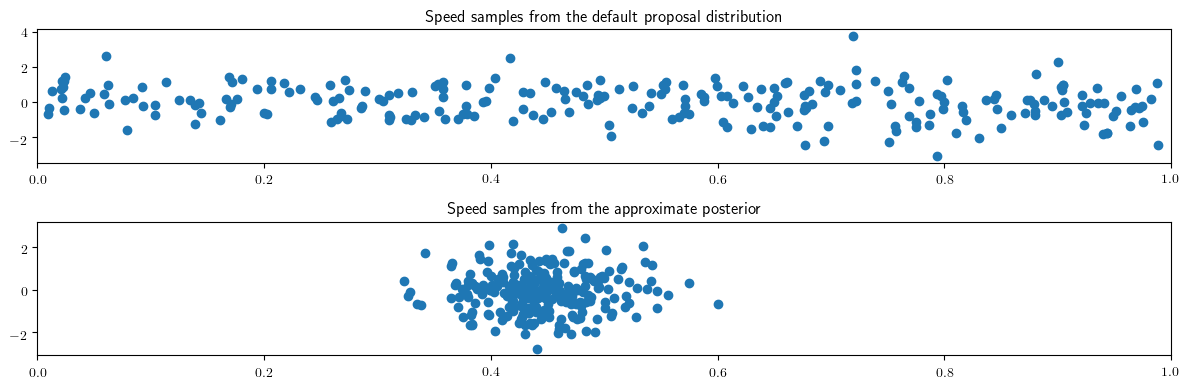

In [41]:
figure(figsize=(12, 4))

subplot(2, 1, 1)
speeds = [let assmt = get_assmt(t); assmt[:speed] end for t in prior_traces];
scatter(speeds, randn(length(prior_traces)))
gca()[:set_xlim](0, 1)
title("Speed samples from the default proposal distribution")

subplot(2, 1, 2)
speeds = [let assmt = get_assmt(t); assmt[:speed] end for t in posterior_traces];
scatter(speeds, randn(length(posterior_traces)))
gca()[:set_xlim](0, 1)
title("Speed samples from the approximate posterior")

tight_layout()

It looks like the posterior distribution on the speed is fairly concentrated in the range 0.4-0.5. We could make our importance sampling algorithm more efficient if we could use a proposal that is closer to this approximate posterior.

Given the measurements, it seems intuitive that we should be able to come up with a good heuristic estimate of the speed, using the distance between consecutive measurements. We ignore successive measurements that are too close together, because these could be sampled from the part of the trajectory after the agent has already reached its destination and stopped. Below we write a function that computes a guess for the speed by taking the median of distance between consecutive data points. This heuristic is based on the assumption that the majority of the agent's paths will be composed of straight-line segments.

In [42]:
function guess_speed(measurements::Vector{Point}, dt::Float64)
    n = length(measurements)
    dists = Vector{Float64}()
    num_used = 0
    for i=1:n-1
        d = dist(measurements[i], measurements[i+1])
        if d > 0.03
            push!(dists, d)
            num_used += 1
        end
    end
    if num_used == 0
        guess = NaN
    else
        guess = median(dists) / dt
    end
    (guess, num_used)
end

guess_speed (generic function with 1 method)

However, this heuristic estimate is unlikely to be accurate if the path planner failed or if the true speed is small, because in these cases the estimate will be completely or partially dominated by the contributions from the measurement noise. Therefore, if there are not enough sufficiently large consecutive distance measurements, we revert to the original default proposal:

In [43]:
@gen function propose_speed(guess::Float64, num_used::Int)
    if num_used > 3
        N = 40
        alpha = guess * (N - 2) + 1
        beta = N - alpha
        @addr(beta_uniform(0.7, alpha, beta), :speed)
    else
        @addr(uniform_continuous(0, 1), :speed)
    end
end

DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[Float64, Int64], getfield(Main, Symbol("##11#13"))(), getfield(Main, Symbol("##12#14"))(), Bool[false, false])

Below, we sample from the custom propsal, and find that it is indeed more concentrated around the posterior distibution for this particular data set:

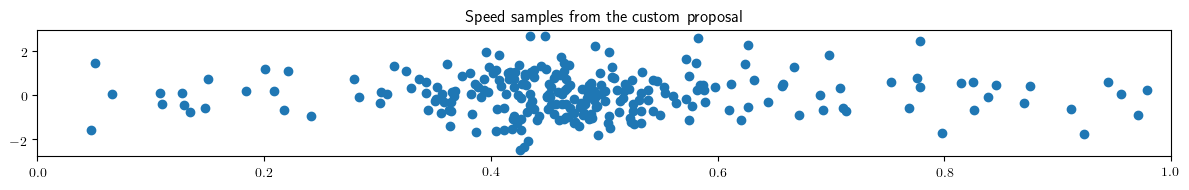

In [44]:
figure(figsize=(12, 2))

speeds = [propose_speed(guess_speed(measurements, dt)...) for _=1:length(posterior_traces)];
scatter(speeds, randn(length(posterior_traces)))
gca()[:set_xlim](0, 1)
title("Speed samples from the custom proposal")

tight_layout()

We can also understand the behavior of the custom proposal on various types of data sets. Below, we take a set of traces sample from the generative model, and plot the true speed (dashed blue line), heuristic estimate (red line), and the resulting custom proposal distribution (orange line).

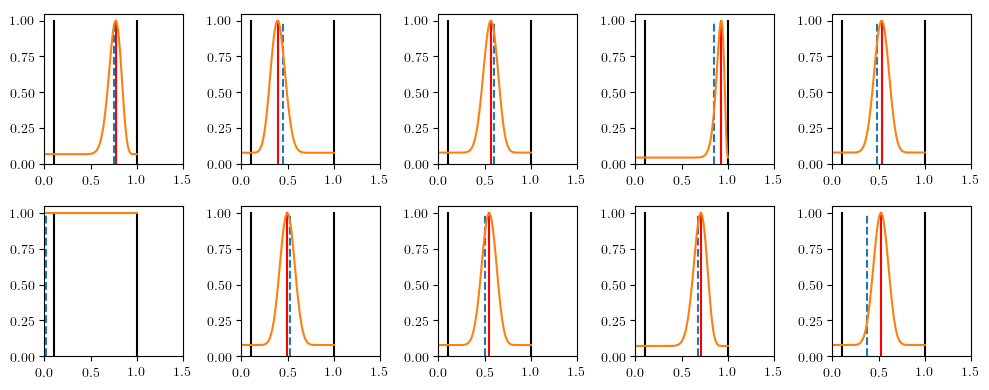

In [45]:
import Statistics
PyPlot.figure(figsize=(10, 4))
for (i, trace) in enumerate(prior_traces[1:10])
    PyPlot.subplot(2, 5, i)
    (start, dest, speed, noise, maybe_path, locations, measurements) = get_retval(trace)
    (guess, num_used) = guess_speed(measurements, dt)
    PyPlot.plot([0.1, 0.1], [0, 1], "k")
    PyPlot.plot([1, 1], [0, 1], "k")
    PyPlot.plot([guess, guess], [0, 1], "r")
    PyPlot.plot([speed, speed], [0, 1], "--")
    pdfs = [let
                assmt = DynamicAssignment();
                assmt[:speed] = s;
                exp(assess(propose_speed, (guess, num_used), assmt)[1])
            end
        for s in 0.0:0.01:1.0]
    PyPlot.plot(0.0:0.01:1.0, pdfs / maximum(pdfs))
    ax = PyPlot.gca()
    ax[:set_xlim](0, 1.5)
    ax[:set_ylim](0, 1.05)
end
PyPlot.tight_layout()

The corresponding data sets are shown below. We find that the proposal is accurate in many cases with sufficiently large speeds and correctly reverts to a generic proposal when the heuristic estimate is unlikely to be accurate.

In [46]:
viz = Viz(server, joinpath(@__DIR__, "grid-viz/dist"), [])
for (i, trace) in enumerate(prior_traces[1:10])
    putTrace!(viz, i, trace_to_dict(trace))
end
displayInNotebook(viz)

Traces (Grid View)

We now use this custom proposal in a new inference algorithm:

In [47]:
function do_inference_custom(scene::Scene, dt::Float64, num_ticks::Int,
                             start::Point, measurements::Vector{Point},
                             num_particles::Int)
    (guess, num_used) = guess_speed(measurements, dt)
    
    observations = DynamicAssignment()
    observations[:start_x] = start.x
    observations[:start_y] = start.y
    for (i, m) in enumerate(measurements)
        observations[:meas => i => :x] = m.x
        observations[:meas => i => :y] = m.y
    end
    
    # use importance sampling with resampling to obtain an inferred trace
    (trace, _) = importance_resampling(model, (scene, dt, num_ticks), observations, 
        propose_speed, (guess, num_used), num_particles)
    
    trace
end

do_inference_custom (generic function with 1 method)

In [48]:
# show results of importance sampling inference (50 particles)
viz = Viz(server, joinpath(@__DIR__, "overlay-viz/dist"), info)
openInNotebook(viz)
sleep(5)
for i=1:1000
    trace = do_inference_custom(scene, dt, num_ticks, start, measurements, 50)
    putTrace!(viz, i, trace_to_dict(trace))
end
displayInNotebook(viz)

>

	<!----> <!----><!----><!---->

We can quantify the change in performance of the algorithm when using the default and custom proposals by comparing the output inferred destination distributions against a gold-standard destination distribution obtained using a large amount of computation. The cell below runs the inference algorithm with the default proposal 1000 times, where each run uses a large number of particles (10000). This cell takes two hours to run. We have already precomputed the results, and we have made this cell not runnable.

Now, we write a function that forms a histogram-based density estimate of the distribution on the destination from a collection of traces.

In [50]:
function make_location_histogram(traces, nrows::Int, ncols::Int, scene::Scene)
    locations = [let a = get_assmt(t); Point(a[:dest_x], a[:dest_y]) end for t in traces]
    counts = fill(0.01, nrows * ncols)
    xspan = scene.xmax - scene.xmin
    yspan = scene.ymax - scene.ymin
    for loc in locations
        row = Int(floor((loc.y - scene.ymin) / yspan * nrows))
        col = Int(floor((loc.x - scene.xmin) / xspan * ncols))
        @assert row < nrows
        @assert col < ncols
        counts[row * ncols + col + 1] += 1
    end
    freqs = counts ./ sum(counts)
    freqs
end

make_location_histogram (generic function with 1 method)

We will use 10 rows and 10 columns in the histogram:

In [51]:
nrows = 10
ncols = 10;

We now generate the gold-standard histogram from the gold-standard traces. We have precomputed the result, so we have made this cell not runnable.

We now load the precomputed results from disk:

In [71]:
gold_standard_histogram = load("gold_standard_histogram.jld", "gold_standard_histogram");

Next, we generate histograms for each of the algorithms we want to compare to the gold standard. We test the default proposal and custom proposal algorithms, for various numbers of particles. We also measure the running time per output sample. This cell takes a few minutes to run.

In [53]:
default_histograms = Dict{Int,Vector{Float64}}()
default_times = Dict{Int,Vector{Float64}}()
custom_histograms = Dict{Int,Vector{Float64}}()
custom_times = Dict{Int,Vector{Float64}}()
num_particles_list = [1, 3, 10, 30, 100]

nruns = 1000
for n in num_particles_list
    
    println("evaluating algorithms with num_particles=$n")
    
    # run importance sampling with default proposal
    traces = Vector{Any}(undef, nruns)
    times = Vector{Float64}(undef, nruns)
    for i=1:nruns
        start_time = time_ns()
        traces[i] = do_inference(scene, dt, num_ticks, start, measurements, n)
        times[i] = (time_ns() - start_time)/1e9
    end
    default_histograms[n] = make_location_histogram(traces, nrows, ncols, scene)
    default_times[n] = times
    
    # run importance sampling with custom proposal
    traces = Vector{Any}(undef, nruns)
    times = Vector{Float64}(undef, nruns)
    for i=1:nruns
        start_time = time_ns()
        traces[i] = do_inference_custom(scene, dt, num_ticks, start, measurements, n)
        times[i] = (time_ns() - start_time)/1e9
    end
    custom_histograms[n] = make_location_histogram(traces, nrows, ncols, scene)
    custom_times[n] = times
end

evaluating algorithms with num_particles=1
evaluating algorithms with num_particles=3
evaluating algorithms with num_particles=10
evaluating algorithms with num_particles=30
evaluating algorithms with num_particles=100


Next, we write a function to compute the KL divergence between two discrete distributions. We will use the KL divergence to measure the difference between the gold-standard output distribution and the output distributions of the algorithms we are evaluating.

In [54]:
function kl_divergence(dist1::Vector{Float64}, dist2::Vector{Float64})
    sum(dist1 .* (log.(dist1) .- log.(dist2)))
end

default_kls = [kl_divergence(gold_standard_histogram, default_histograms[n]) for n in num_particles_list]
default_median_elapsed = [median(default_times[n]) for n in num_particles_list]

custom_kls = [kl_divergence(gold_standard_histogram, custom_histograms[n]) for n in num_particles_list]
custom_median_elapsed = [median(custom_times[n]) for n in num_particles_list];

Finally, we plot the results. On the left, we plot the error as measured against the gold standard (KL divergence) as a function of the number of particles used in the importance smapling algorithm. On the right we plot the error versus the median time per run of the algorithm

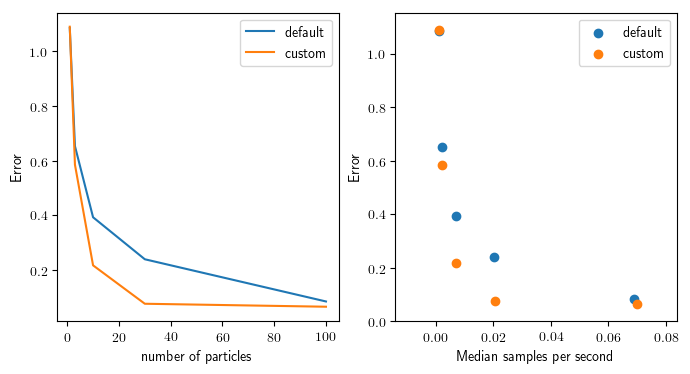

PyObject Text(0.5, 24.0, 'Median samples per second')

In [72]:
PyPlot.figure(figsize=(8, 4))

PyPlot.subplot(1, 2, 1)
PyPlot.plot(num_particles_list, default_kls, label="default")
PyPlot.plot(num_particles_list, custom_kls, label="custom")
PyPlot.legend()
PyPlot.ylabel("Error")
PyPlot.xlabel("number of particles")

PyPlot.subplot(1, 2, 2)
PyPlot.scatter(default_median_elapsed, default_kls, label="default")
PyPlot.scatter(custom_median_elapsed, custom_kls, label="custom")
PyPlot.legend()
PyPlot.ylabel("Error")
PyPlot.xlabel("Median samples per second")

From the plot on the right, we see that there is a regime where using the custom proposal gives less than half the error over using the default proposal, for the same amount of running time.

## Step 7: Learning a custom proposal

It was not too difficult to design a custom proposal for the speed based on a heuristic estimator. However, sometimes it is not straightforward to manually design a custom proposal. In such cases, we can still design a *sketch* for a custom proposal, and *train* the parameters of the proposal automatically, to fill in our missing knowledge, or to generate code that it would be hard to program by hand.

For example, consider the destination. The default proposal distribution for the destination is the uniform distribution on the scene region. Intuitively, it should be possible to for a short and fast program to narrow down the scene region based on the measurements. However, writing a program that is robust, by hand, is challening. This section shows how to learn a custom proposal for the destination from data simulated from the model. The idea of training proposal distribution on data simulated from a generative model has been called *amortized inference* [3] and *inference compilation* [4], and is also the core of the wake-sleep algorithm [5].


- [3] Stuhlmüller, Andreas, Jacob Taylor, and Noah Goodman. "Learning stochastic inverses." Advances in neural information processing systems. 2013.

- [4] Le, Tuan Anh, Atilim Gunes Baydin, and Frank Wood. "Inference compilation and universal probabilistic programming." arXiv preprint arXiv:1610.09900 (2016).

- [5] Hinton, Geoffrey E., et al. "The" wake-sleep" algorithm for unsupervised neural networks." Science 268.5214 (1995): 1158-1161.

In [56]:
sigmoid(x) = 1 ./ (1 .+ exp.(-x))

sigmoid (generic function with 1 method)

In [57]:
function dest_x_neural_net(nn_params, x_first::Real, y_first::Real, x_last::Real, y_last::Real)
    (W1, b1, W2, b2, W3, b3) = nn_params
    input_layer = [x_first, y_first, x_last, y_last]
    hidden_layer_1 = sigmoid(W1 * input_layer .+ b1)
    hidden_layer_2 = sigmoid(W2 * hidden_layer_1 .+ b2)
    output_layer = exp.(W3 * hidden_layer_2 .+ b3)
end

function dest_y_neural_net(nn_params, x_first::Real, y_first::Real, x_last::Real, y_last::Real, dest_x::Real)
    (W1, b1, W2, b2, W3, b3) = nn_params
    input_layer = [x_first, y_first, x_last, y_last, dest_x]
    hidden_layer_1 = sigmoid(W1 * input_layer .+ b1)
    hidden_layer_2 = sigmoid(W2 * hidden_layer_1 .+ b2)
    output_layer = exp.(W3 * hidden_layer_2 .+ b3)
end

@gen function custom_dest_proposal(measurements::Vector{Point}, scene::Scene)
        
    @param x_W1::Matrix{Float64}
    @param x_b1::Vector{Float64}
    @param x_W2::Matrix{Float64}
    @param x_b2::Vector{Float64}
    @param x_W3::Matrix{Float64}
    @param x_b3::Vector{Float64}
    
    @param y_W1::Matrix{Float64}
    @param y_b1::Vector{Float64}
    @param y_W2::Matrix{Float64}
    @param y_b2::Vector{Float64}
    @param y_W3::Matrix{Float64}
    @param y_b3::Vector{Float64}
    
    num_x_bins = length(x_b3)
    num_y_bins = length(y_b3)
    
    x_first = measurements[1].x
    x_last = measurements[end].x
    y_first = measurements[1].y
    y_last = measurements[end].y
    
    # sample dest_x
    x_bounds = collect(range(scene.xmin, stop=scene.xmax, length=num_x_bins+1))
    x_probs = dest_x_neural_net((x_W1, x_b1, x_W2, x_b2, x_W3, x_b3), x_first, y_first, x_last, y_last)
    dest_x = @addr(Gen.piecewise_uniform(x_bounds, x_probs / sum(x_probs)), :dest_x)
    
    # sample dest_y
    y_bounds = collect(range(scene.xmin, stop=scene.xmax, length=num_y_bins+1))
    y_probs = dest_y_neural_net((y_W1, y_b1, y_W2, y_b2, y_W3, y_b3), x_first, y_first, x_last, y_last, dest_x)
    @addr(Gen.piecewise_uniform(y_bounds, y_probs / sum(y_probs)), :dest_y)
    
    nothing
end

num_x_bins = 5
num_y_bins = 5

# architecture of the neural network
num_hidden_1 = 50
num_hidden_2 = 50

import Random
Random.seed!(1)

# set parameters for dest_x_neural_net predictor network
init_param!(custom_dest_proposal, :x_W1, 0.001 * rand(num_hidden_1, 4))
init_param!(custom_dest_proposal, :x_b1, 0.001 * rand(num_hidden_1))
init_param!(custom_dest_proposal, :x_W2, 0.001 * rand(num_hidden_2, num_hidden_1))
init_param!(custom_dest_proposal, :x_b2, 0.001 * rand(num_hidden_2))
init_param!(custom_dest_proposal, :x_W3, 0.001 * rand(num_x_bins, num_hidden_2))
init_param!(custom_dest_proposal, :x_b3, 0.001 * rand(num_x_bins))

# set parameters for dest_y_neural_net predictor network
init_param!(custom_dest_proposal, :y_W1, 0.001 * rand(num_hidden_1, 5))
init_param!(custom_dest_proposal, :y_b1, 0.001 * rand(num_hidden_1))
init_param!(custom_dest_proposal, :y_W2, 0.001 * rand(num_hidden_2, num_hidden_1))
init_param!(custom_dest_proposal, :y_b2, 0.001 * rand(num_hidden_2))
init_param!(custom_dest_proposal, :y_W3, 0.001 * rand(num_y_bins, num_hidden_2))
init_param!(custom_dest_proposal, :y_b3, 0.001 * rand(num_y_bins));

Next, we visualize the proposal density for a given data set. The cell below computes the proposal density at a a grid of points in the scene, and returns a list of `tiles` that can be rendered on top of the scene by the visualization.

In [58]:
function make_proposal_tiles(measurements::Vector{Point}, scene::Scene, num_x_bins::Int, num_y_bins::Int)
    dest_proposal_tiles = []
    xspan = scene.xmax - scene.xmin
    yspan = scene.ymax - scene.ymin
    w = xspan / num_x_bins
    h = yspan / num_y_bins
    for col=1:num_x_bins
        for row=1:num_y_bins
            x = scene.xmin + (col - 1) * w
            y = scene.ymin + (row - 1) * h
            assmt = DynamicAssignment()
            assmt[:dest_x] = x + (w/2)
            assmt[:dest_y] = y + (h/2)
            (weight, _) = assess(custom_dest_proposal, (measurements, scene), assmt)
            tile = Dict("x" => x, "y" => y, "w" => w, "h" => h, "density" => exp(weight))
            push!(dest_proposal_tiles, tile)
        end
    end
    max_density = maximum([tile["density"] for tile in dest_proposal_tiles])
    for tile in dest_proposal_tiles
        tile["density"] /= max_density
    end
    dest_proposal_tiles
end

make_proposal_tiles (generic function with 1 method)

First, we show the proposal distribution prior to training:

In [59]:
tiles = make_proposal_tiles(measurements, scene, 5, 5)
info = Dict("measurements" => measurements, "scene" => scene, "start" => start, "tiles" => tiles)
viz = Viz(server, joinpath(@__DIR__, "overlay-viz/dist"), info)
displayInNotebook(viz)

>

	<!----> <!----><!---->

We see that the entire scene is colored the same color. The untrained proposal is approximately uniform on the entire scene, just like the default proposal.



Next, we train the network using stochastic gradient descent.

In [60]:
optimizer = SGDOptimizer(Set(get_param_names(custom_dest_proposal)), 10, 10000, 100, 100;
    step_size_init=0.1, step_size_beta=1000)

function data_generator()
    
    local assmt
    
    # obtain a trace of the model where planning succeeded
    done = false
    while !done
        (assmt, _, retval) = propose(model, (scene, dt, num_ticks))
        (start, dest, speed, noise, maybe_path) = retval
        done = (maybe_path != nothing)
    end

    measurements = [Point(assmt[:meas => i => :x], assmt[:meas => i => :y]) for i=1:num_ticks]
    inputs = (measurements, scene)
    
    constraints = DynamicAssignment()
    constraints[:dest_x] = assmt[:dest_x]
    constraints[:dest_y] = assmt[:dest_y]
    
    (inputs, constraints)
end

data_generator (generic function with 1 method)

In [61]:
train!(optimizer, custom_dest_proposal, data_generator, verbose=true)

generating data for epoch 1
training for epoch 1...
epoch 1 avg score: -0.12595865675376455
generating data for epoch 2
training for epoch 2...
epoch 2 avg score: 0.12329196857438003
generating data for epoch 3
training for epoch 3...
epoch 3 avg score: 0.14270040506575482
generating data for epoch 4
training for epoch 4...
epoch 4 avg score: 0.33740799845409053
generating data for epoch 5
training for epoch 5...
epoch 5 avg score: 0.21860958290699287
generating data for epoch 6
training for epoch 6...
epoch 6 avg score: 0.4026014236225694
generating data for epoch 7
training for epoch 7...
epoch 7 avg score: 0.17596296690811689
generating data for epoch 8
training for epoch 8...
epoch 8 avg score: 0.37648323811819356
generating data for epoch 9
training for epoch 9...
epoch 9 avg score: 0.36576712566672903
generating data for epoch 10
training for epoch 10...
epoch 10 avg score: 0.4054303227789739


We now visualize the trained proposal distribution for the given data set:

In [62]:
tiles = make_proposal_tiles(measurements, scene, 5, 5)
info = Dict("measurements" => measurements, "scene" => scene, "start" => start, "tiles" => tiles)
viz = Viz(server, joinpath(@__DIR__, "overlay-viz/dist"), info)
displayInNotebook(viz)

>

	<!----> <!----><!---->

For this data set, the proposal distribution seems to make sense.

We now can combine the custom proposal for the destination with the custom proposal for the speed:

In [63]:
@gen function custom_proposal(measurements::Vector{Point}, scene::Scene, guess, num_used)
    @splice(custom_dest_proposal(measurements, scene))
    @splice(propose_speed(guess, num_used))
end

DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[Array{Point,1}, Scene, Any, Any], getfield(Main, Symbol("##37#39"))(), getfield(Main, Symbol("##38#40"))(), Bool[false, false, false, false])

We write a new inference algorithm that uses importance sampling based on this new trained proposal:

In [64]:
function do_inference_trained(scene::Scene, dt::Float64, num_ticks::Int,
                              start::Point, measurements::Vector{Point},
                              num_particles::Int)
    (guess, num_used) = guess_speed(measurements, dt)
    
    observations = DynamicAssignment()
    observations[:start_x] = start.x
    observations[:start_y] = start.y
    for (i, m) in enumerate(measurements)
        observations[:meas => i => :x] = m.x
        observations[:meas => i => :y] = m.y
    end
    
    # use importance sampling with resampling to obtain an inferred trace
    (trace, _) = importance_resampling(model, (scene, dt, num_ticks), observations, 
        custom_proposal, (measurements, scene, guess, num_used), num_particles)
    
    trace
end

do_inference_trained (generic function with 1 method)

Below, we show some samples from this new algorithm.

In [65]:
info = Dict("measurements" => measurements, "scene" => scene, "start" => start)
viz = Viz(server, joinpath(@__DIR__, "overlay-viz/dist"), info)
openInNotebook(viz)
sleep(5)
for i=1:1000
    trace = do_inference_trained(scene, dt, num_ticks, start, measurements, 50)
    putTrace!(viz, i, trace_to_dict(trace))
end
displayInNotebook(viz)

>

	<!----> <!----><!----><!---->

We now generate histograms for the destination distributions for the new algorithm, for various numbers of particles.

In [66]:
trained_histograms = Dict{Int,Vector{Float64}}()
trained_times = Dict{Int,Vector{Float64}}()
num_particles_list = [1, 3, 10, 30, 100]

nruns = 1000
for n in num_particles_list
    
    println("evaluating algorithms with num_particles=$n")
    
    # run importance sampling with default proposal
    traces = Vector{Any}(undef, nruns)
    times = Vector{Float64}(undef, nruns)
    for i=1:nruns
        start_time = time_ns()
        traces[i] = do_inference_trained(scene, dt, num_ticks, start, measurements, n)
        times[i] = (time_ns() - start_time)/1e9
    end
    trained_histograms[n] = make_location_histogram(traces, nrows, ncols, scene)
    trained_times[n] = times
end

evaluating algorithms with num_particles=1
evaluating algorithms with num_particles=3
evaluating algorithms with num_particles=10
evaluating algorithms with num_particles=30
evaluating algorithms with num_particles=100


We compute KL divergences between the gold standard distribution and these histograms.

In [67]:
trained_kls = [kl_divergence(gold_standard_histogram, trained_histograms[n]) for n in num_particles_list]
trained_median_elapsed = [median(trained_times[n]) for n in num_particles_list];

Below, we plot the results and compare the three importance sampling algorithms developed in this notebook.

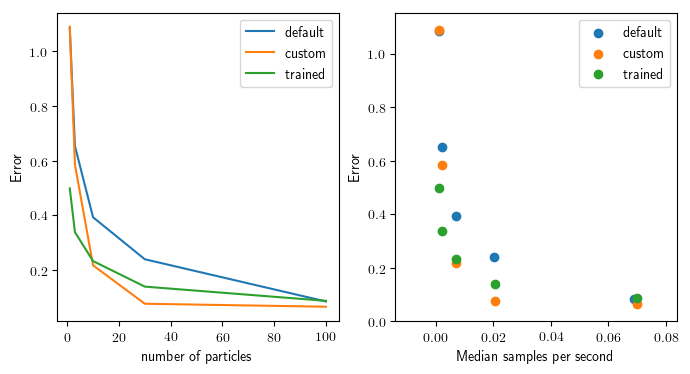

PyObject Text(0.5, 24.0, 'Median samples per second')

In [73]:
PyPlot.figure(figsize=(8, 4))

PyPlot.subplot(1, 2, 1)
PyPlot.plot(num_particles_list, default_kls, label="default")
PyPlot.plot(num_particles_list, custom_kls, label="custom")
PyPlot.plot(num_particles_list, trained_kls, label="trained")
PyPlot.legend()
PyPlot.ylabel("Error")
PyPlot.xlabel("number of particles")

PyPlot.subplot(1, 2, 2)
PyPlot.scatter(default_median_elapsed, default_kls, label="default")
PyPlot.scatter(custom_median_elapsed, custom_kls, label="custom")
PyPlot.scatter(custom_median_elapsed, trained_kls, label="trained")
PyPlot.legend()
PyPlot.ylabel("Error")
PyPlot.xlabel("Median samples per second")